In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load pretrained model and test data

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [3]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
npzfile = np.load('dataset/test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [6]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [7]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)
# X_test = np.expand_dims(X_test, axis = -1)
print(X_test.shape)

(800, 640, 128)


### Extract embeddings from the concat layer of the model

In [8]:
layer_name = 'dense1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [9]:
print(intermediate_output.shape)

(800, 64)


In [10]:
# print(intermediate_output[:2])

### Cluster using K means

In [11]:
from sklearn.cluster import KMeans, SpectralClustering

In [12]:
kmeans = KMeans(n_clusters=8, init='random', verbose =1).fit(intermediate_output)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3905.5667
start iteration
done sorting
end inner loop
Iteration 1, inertia 3516.824
start iteration
done sorting
end inner loop
Iteration 2, inertia 3325.8494
start iteration
done sorting
end inner loop
Iteration 3, inertia 3164.2139
start iteration
done sorting
end inner loop
Iteration 4, inertia 3060.7249
start iteration
done sorting
end inner loop
Iteration 5, inertia 3034.2087
start iteration
done sorting
end inner loop
Iteration 6, inertia 3018.1672
start iteration
done sorting
end inner loop
Iteration 7, inertia 3007.9026
start iteration
done sorting
end inner loop
Iteration 8, inertia 2997.4807
start iteration
done sorting
end inner loop
Iteration 9, inertia 2993.1743
start iteration
done sorting
end inner loop
Iteration 10, inertia 2987.174
start iteration
done sorting
end inner loop
Iteration 11, inertia 2978.8352
start iteration
done sorting
end inner loop
Iteration 12, inertia 2972.2412


Iteration 40, inertia 2449.4077
start iteration
done sorting
end inner loop
Iteration 41, inertia 2447.356
start iteration
done sorting
end inner loop
Iteration 42, inertia 2444.1155
start iteration
done sorting
end inner loop
Iteration 43, inertia 2439.6086
start iteration
done sorting
end inner loop
Iteration 44, inertia 2435.8818
start iteration
done sorting
end inner loop
Iteration 45, inertia 2432.619
start iteration
done sorting
end inner loop
Iteration 46, inertia 2430.922
start iteration
done sorting
end inner loop
Iteration 47, inertia 2429.7844
start iteration
done sorting
end inner loop
Iteration 48, inertia 2429.7844
center shift 0.000000e+00 within tolerance 1.690895e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4797.1055
start iteration
done sorting
end inner loop
Iteration 1, inertia 3365.3752
start iteration
done sorting
end inner loop
Iteration 2, inertia 2915.4888
start iteration
done sorting
end inner loop
Iteration 3, i

In [13]:
labels = kmeans.labels_
labels.shape

(800,)

In [14]:
print(labels)

[0 4 3 3 4 4 3 6 7 0 0 0 6 4 0 3 0 6 4 4 6 4 4 2 7 4 3 4 7 4 6 7 7 7 3 6 6
 7 0 3 6 3 6 7 7 1 7 3 0 0 6 0 6 6 6 5 6 1 3 3 3 0 2 2 5 0 0 6 0 7 3 6 6 0
 6 0 5 0 5 7 6 0 6 0 3 6 0 0 0 6 6 5 1 6 0 6 1 6 7 6 6 2 0 2 2 0 1 2 1 4 4
 4 4 4 4 3 7 3 7 0 4 3 6 6 0 0 6 0 7 6 0 0 6 0 0 2 0 0 3 3 7 0 7 0 5 2 1 3
 4 4 2 0 2 0 4 6 0 1 0 3 6 4 4 4 4 3 4 1 0 2 1 6 1 6 2 4 1 4 0 6 0 6 0 0 3
 4 0 3 4 3 4 2 3 0 4 4 2 4 5 3 5 5 5 3 3 5 3 3 3 3 3 5 3 4 3 3 5 3 3 3 3 7
 3 3 3 6 6 1 4 3 6 6 6 6 6 3 6 6 3 6 3 0 0 6 6 3 0 4 2 2 6 4 2 3 3 3 6 3 3
 4 4 4 3 0 3 5 3 3 3 3 3 3 3 3 3 3 0 0 0 2 4 7 6 7 6 1 0 5 4 5 1 2 1 1 6 7
 0 6 6 6 0 0 6 6 7 5 0 6 1 7 7 7 7 4 1 5 3 2 3 3 3 5 3 3 3 3 3 3 6 3 4 4 7
 4 5 6 6 6 0 6 6 6 6 0 4 6 4 2 4 1 1 1 1 0 1 0 1 4 6 1 5 3 6 4 1 6 6 6 4 0
 2 4 4 1 4 4 4 2 0 4 4 4 6 1 1 7 2 1 4 1 1 1 1 0 2 4 5 5 0 2 4 2 0 4 6 7 3
 2 2 6 6 6 0 0 7 0 0 0 2 0 4 0 2 4 0 0 2 0 4 6 6 6 6 2 4 2 2 7 2 4 2 1 4 2
 5 7 3 3 6 7 3 0 0 6 5 7 5 5 5 5 1 1 7 0 4 4 1 1 0 2 0 0 3 3 3 0 1 2 2 2 1
 0 5 5 0 0 5 7 4 4 7 0 0 

### Evaluate the output from K-means 

#### Adjusted Rand Index

In [15]:
from sklearn.metrics import adjusted_rand_score

In [16]:
adjusted_rand_score(y_test, labels)

0.21904571631792435

#### Try different number of clusters

In [17]:
from sklearn.metrics import silhouette_score

for cluster in range(2,10):
    kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
    labels = kmeans.labels_
    score = silhouette_score(intermediate_output, labels, metric='euclidean')
    print("Cluster number and Score is: ", cluster, score)

Cluster number and Score is:  2 0.27497897
Cluster number and Score is:  3 0.27744186
Cluster number and Score is:  4 0.2723991
Cluster number and Score is:  5 0.27508077
Cluster number and Score is:  6 0.29554057
Cluster number and Score is:  7 0.29196498
Cluster number and Score is:  8 0.30197707
Cluster number and Score is:  9 0.28685796


### Visualizations

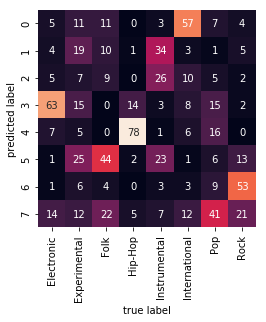

In [20]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns
cluster = 8
kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
labels = kmeans.labels_

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');



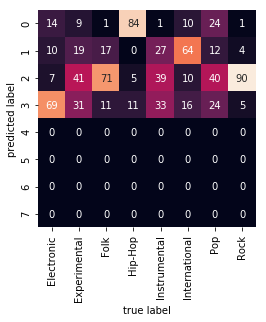

In [21]:
### 4 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns
cluster = 4
kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
labels = kmeans.labels_

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

